# <center>Data Mining Project</center>

<center>
Master in Data Science and Advanced Analytics <br>
NOVA Information Management School
</center>

** **
## <center>*ABCDEats Inc*</center>

<center>
Group 19 <br>
Jan-Louis Schneider, 20240506  <br>
Marta Boavida, 20240519  <br>
Matilde Miguel, 20240549  <br>
Sofia Gomes, 20240848  <br>
</center>

** **

In [40]:
!jupyter nbconvert --to script "Processing_Data.ipynb"

[NbConvertApp] Converting notebook Processing_Data.ipynb to script
[NbConvertApp] Writing 25172 bytes to Processing_Data.py


In [41]:
import pandas as pd 
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import scipy.stats as stats
import warnings

from math import ceil
from sklearn.impute import KNNImputer

from Processing_Data import *

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [42]:
df = pd.read_csv("../dataset/df_preprocessing.csv")

## <span style="color:salmon">3.1 New Features </span> 

Creating new features can significantly enhance our analysis by providing additional insights and improving the performance of models

#### <span style="color:salmon"> 3.1.1 Customer Lifetime  </span>
Interval of customer activity, so we have an idea of ​​how many days the customer ordered.

In [43]:
df['lifetime_days'] = df['last_order'] - df['first_order']
df['lifetime_days'].dtype

dtype('float64')

#### <span style="color:salmon"> 3.1.2 Most frequent order day of the week  </span>
Indicates the days of the week on which the customer placed the most orders.

In [44]:
dows = ['DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'DOW_0'] # this order so it is from Monday to Sunday, not Sunday to Saturday]
def frequent_days(customer):
    max_value = customer[dows].max() # Day with the most orders
    result = []
    for col in dows: # Checks if there is more than one day with max_value
        if customer[col] == max_value:
            result.append(col)
    return result

df['preferred_order_days'] = df.apply(frequent_days, axis=1)
df['preferred_order_days'].dtype # obj 
all(isinstance(i, list) for i in df['preferred_order_days']) # confirm that all values ​​are lists

True

#### <span style="color:salmon"> 3.1.3 Most frequent part of the day  </span>
6h-12h --> Morning (Breakfast)  
12h-18h --> Afternoon (Lunch)  
18h-00h --> Evening (Dinner)  
00h-6h --> Night

In [45]:
def part_of_the_day(hour):
    if 6 <= hour < 12:
        return '06h-12h'
    elif 12 <= hour < 18:
        return '12h-18h'
    elif 18 <= hour < 24:
        return '18h-00h'
    else:  # 0 <= hour < 6
        return '00h-06h'

def frequent_hours(customer):
    part_counts = {
        '06h-12h': 0,
        '12h-18h': 0,
        '18h-00h': 0,
        '00h-06h': 0}
    for hour in range(24):
        num_orders = customer[f'HR_{hour}']
        if pd.isna(num_orders): # Ignore NaN
            continue
        part_of_day = part_of_the_day(hour)
        part_counts[part_of_day] += num_orders

    # Part of the day with the highest number of orders
    max_value = 0
    result = []
    for part, count in part_counts.items():
        if count > max_value:
            max_value = count  
            result = [part] 
        elif count == max_value:
            result.append(part) 
    return result
    
df['preferred_part_of_day'] = df.apply(frequent_hours, axis=1)
df['preferred_part_of_day'].dtype # obj 
all(isinstance(i, list) for i in df['preferred_part_of_day']) # confirm that all values ​​are lists

True

#### <span style="color:salmon"> 3.1.4 Total monetary units spend </span>
Sum all total expenses.

In [46]:
cuisine = df.filter(like='CUI_').columns.tolist() # Types of cuisine
df['total_expenses'] = df[cuisine].sum(axis=1)
df['total_expenses'].dtype

dtype('float64')

#### <span style="color:salmon"> 3.1.5 Average monetary units per product </span>
Show the average monetary of all products.

In [47]:
df['avg_per_product'] = pd.to_numeric(df['total_expenses'] / df['product_count'].replace(0, pd.NA), errors='coerce')
df['avg_per_product'].dtype

dtype('float64')

#### <span style="color:salmon"> 3.1.6 Average monetary units per order </span>
Show the average monetary per order. 

In [48]:
df['avg_per_order'] = pd.to_numeric(df['total_expenses'] / df[dows].sum(axis=1).replace(0, pd.NA), errors='coerce')
df['avg_per_order'].dtype

dtype('float64')

#### <span style="color:salmon"> 3.1.7 Average order size </span>
Help identifying users who make larger orders.

In [49]:
df['avg_order_size'] = pd.to_numeric(df['product_count'] / df[dows].sum(axis=1).replace(0, pd.NA), errors='coerce')
df['avg_order_size'].dtype

dtype('float64')

#### <span style="color:salmon"> 3.1.8 Culinary profile </span>
A proportion of ordered cuisines. A higher number indicates more diversity of types of cuisine you ordered.

In [50]:
total_cuisine = len(cuisine)

df['culinary_variety'] = round((df[cuisine].gt(0).sum(axis=1) / total_cuisine), 5)
df['culinary_variety'].dtype

dtype('float64')

#### <span style="color:salmon"> 3.1.9 Loyalty to chain restaurants </span>
Proportion of orders from restaurant chains. A high value indicates that you prefer to try different restaurant chains. A lower value is only more faithful to certain chains.

In [51]:
df['chain_preference'] = pd.to_numeric(df['is_chain'] / df[dows].sum(axis=1).replace(0, pd.NA), errors='coerce')
df['chain_preference'].dtype

dtype('float64')

#### <span style="color:salmon"> 3.1.10 Loyalty to venders </span>
Proportion of orders from specific restaurants. A high value indicates that you prefer to try different restaurants. A lower tend to be more loyal to specific restaurants.

In [52]:
df['loyalty_to_venders'] = pd.to_numeric(df['vendor_count'] / df[dows].sum(axis=1).replace(0, pd.NA), errors='coerce')
df['loyalty_to_venders'].dtype

dtype('float64')

To see all the new features that we added:

In [53]:
df.head(20)

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,lifetime_days,preferred_order_days,preferred_part_of_day,total_expenses,avg_per_product,avg_per_order,avg_order_size,culinary_variety,chain_preference,loyalty_to_venders
0,2360.0,18.0,2,5.0,1,0.0,1,DELIVERY,DIGI,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,28.88,0.0,0.00,0.0,0.0,0.00,0.0,1,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1.0,"[DOW_6, DOW_0]",[18h-00h],28.88,5.776000,14.440000,2.500000,0.06667,0.500000,1.0
1,8670.0,17.0,2,2.0,2,0.0,1,DISCOUNT,DIGI,12.82,6.39,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,1,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1.0,"[DOW_6, DOW_0]",[06h-12h],19.21,9.605000,9.605000,1.000000,0.13333,1.000000,1.0
2,4660.0,38.0,1,2.0,2,0.0,1,DISCOUNT,CASH,9.20,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,1,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.0,"[DOW_6, DOW_0]",[06h-12h],9.20,4.600000,4.600000,1.000000,0.06667,1.000000,0.5
3,4660.0,26.0,2,3.0,1,0.0,2,DELIVERY,DIGI,0.00,13.70,0.00,0.0,0.00,0.00,0.0,0.00,17.86,0.0,0.00,0.0,0.0,0.00,0.0,0,1,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2.0,"[DOW_1, DOW_6]","[06h-12h, 12h-18h]",31.56,10.520000,15.780000,1.500000,0.13333,0.500000,1.0
4,4660.0,20.0,2,5.0,0,0.0,2,DELIVERY,DIGI,14.57,40.87,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0,1,0,0,0,0,1,0.0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,"[DOW_1, DOW_6]",[06h-12h],55.44,11.088000,27.720000,2.500000,0.13333,0.000000,1.0
5,8670.0,40.0,2,2.0,0,0.0,2,FREEBIE,DIGI,0.00,24.92,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0,1,0,0,0,0,1,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,"[DOW_1, DOW_6]",[00h-06h],24.92,12.460000,12.460000,1.000000,0.06667,0.000000,1.0
6,2440.0,24.0,2,2.0,2,0.0,2,DELIVERY,CARD,5.88,0.00,1.53,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0,1,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,2.0,"[DOW_1, DOW_6]","[06h-12h, 12h-18h]",7.41,3.705000,3.705000,1.000000,0.13333,1.000000,1.0
7,8670.0,27.0,2,3.0,2,0.0,2,DISCOUNT,DIGI,11.71,0.00,24.40,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0,1,0,0,0,0,1,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2.0,"[DOW_1, DOW_6]","[06h-12h, 12h-18h]",36.11,12.036667,18.055000,1.500000,0.13333,1.000000,1.0
8,2360.0,20.0,3,4.0,2,0.0,3,DISCOUNT,DIGI,2.75,0.00,0.00,0.0,0.00,0.00,0.0,4.39,0.00,0.0,0.00,0.0,7.3,0.00,0.0,0,0,1,0,0,0,2,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,3.0,[DOW_6],[18h-00h],14.44,3.610000,4.813333,1.333333,0.20000,0.666667,1.0
9,8670.0,20.0,2,3.0,0,0.0,3,DELIVERY,CARD,0.00,32.48,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0,0,1,0,0,0,1,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,"[DOW_2, DOW_6]",[00h-06h],32.48,10.826667,16.240000,1.500000,0.06667,0.000000,1.0


## <span style="color:salmon">3.2 New metric and non metric features </span> 

New metric and non metric features:

In [54]:
new_metric_features = ['lifetime_days', 'total_expenses', 'avg_per_product', 'avg_per_order', 'avg_order_size', 'culinary_variety', 'chain_preference', 'loyalty_to_venders']
new_non_metric_features = ['preferred_order_days', 'preferred_part_of_day']
new_features = new_metric_features + new_non_metric_features

Descriptives:

In [55]:
df[new_features].describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
lifetime_days,31326.0,NaN,NaN,NaN,34.585743,29.115557,0.0,2.0,33.0,61.0,90.0
total_expenses,31326.0,NaN,NaN,NaN,35.311061,36.560119,0.0,12.72,23.91,43.3975,440.32
avg_per_product,31188.0,NaN,NaN,NaN,7.587677,4.063717,0.37,4.136667,6.9525,10.15,24.39
avg_per_order,31188.0,NaN,NaN,NaN,10.292254,7.84593,0.37,5.0675,8.216667,12.894062,104.32
avg_order_size,31188.0,NaN,NaN,NaN,1.296173,0.416002,1.0,1.0,1.166667,1.5,6.0
culinary_variety,31326.0,NaN,NaN,NaN,0.148829,0.09499,0.0,0.06667,0.13333,0.2,0.8
chain_preference,31188.0,NaN,NaN,NaN,0.627151,0.388283,0.0,0.333333,0.724747,1.0,1.0
loyalty_to_venders,31188.0,NaN,NaN,NaN,0.844642,0.224045,0.052632,0.666667,1.0,1.0,1.0
preferred_order_days,31326,127,[DOW_6],3588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
preferred_part_of_day,31326,15,[12h-18h],11422,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Missing values:

In [56]:
missing_rows = df[new_features].isna().any(axis=1)

In [57]:
# Percentage of missing values in each variable:
missing_percentage = ((df[new_features].isnull().sum() / len(df)) * 100).sort_values(ascending=False)
missing_percentage = missing_percentage[missing_percentage > 0]

print(f"Percentage of missing values:\n {missing_percentage}")

Percentage of missing values:
 avg_per_order         0.440529
avg_per_product       0.440529
loyalty_to_venders    0.440529
chain_preference      0.440529
avg_order_size        0.440529
dtype: float64


Visualize new numerical metric features:

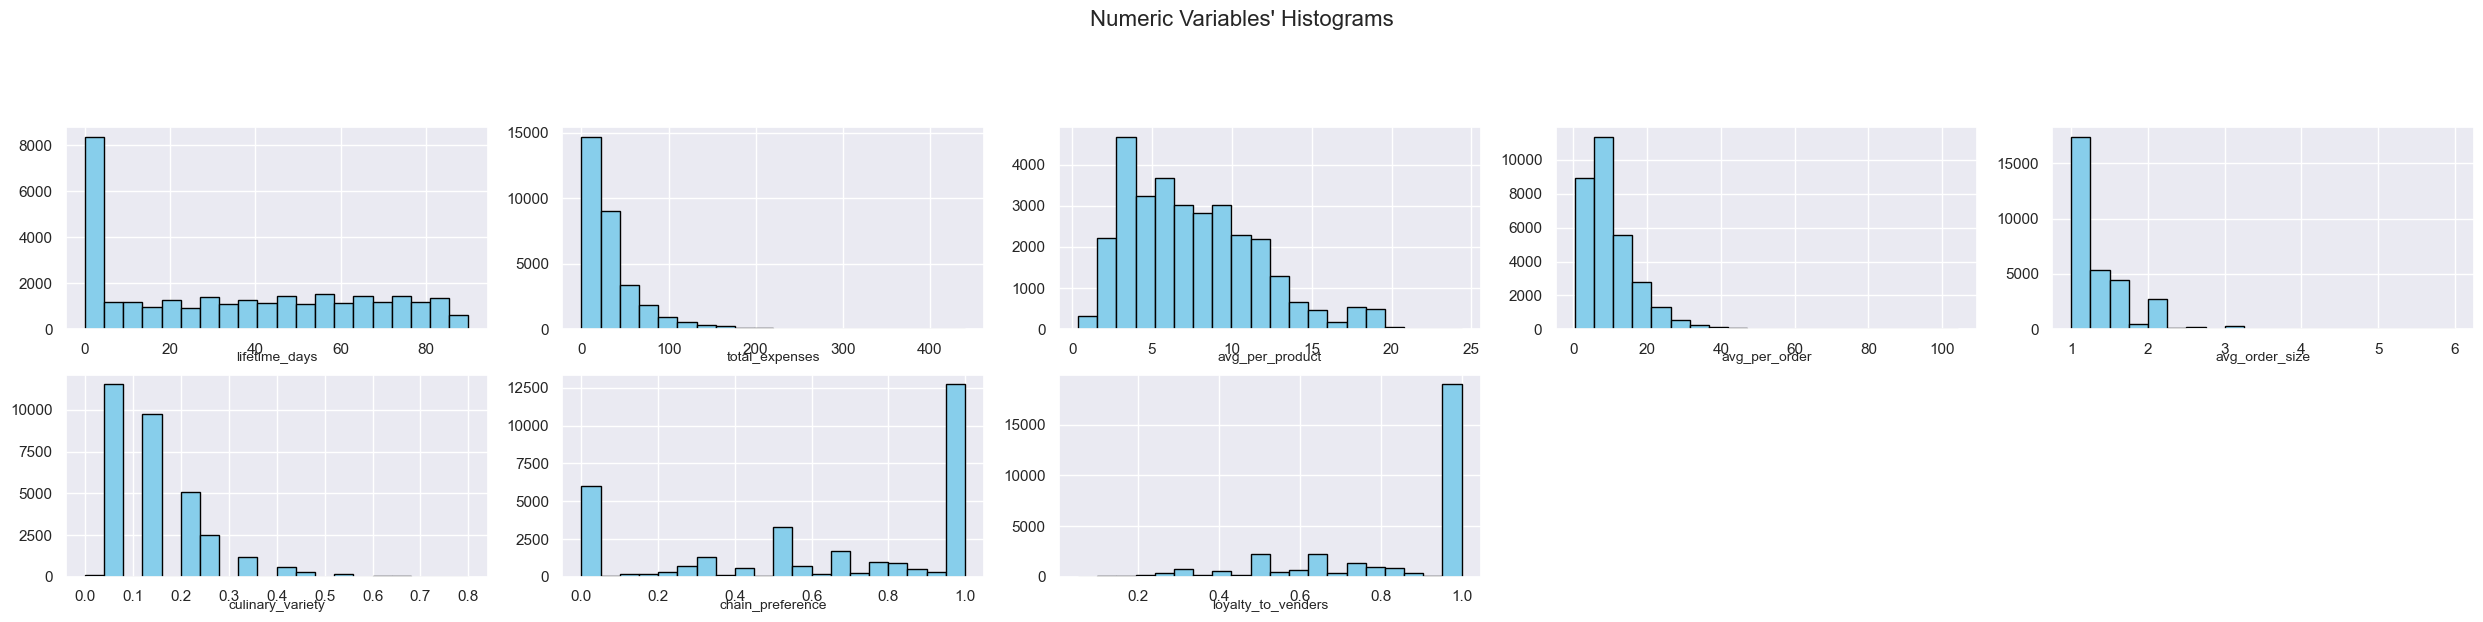

In [58]:
sns.set()

# Set up the figure and axes
rows, cols = 12, 5 
fig, axes = plt.subplots(rows, cols, figsize=(25, 30))  

# Plot each feature
for ax, feat in zip(axes.flatten(), new_metric_features):
    ax.hist(df[feat], bins=20, color='skyblue', edgecolor='black')  
    ax.set_title(feat, fontsize=10, y=-0.2)  

# Hide unused subplots:
for ax in axes.flatten()[len(new_metric_features):]:
    ax.set_visible(False)

# Set a global title and adjust layout
plt.suptitle("Numeric Variables' Histograms", fontsize=16, y=1.02)  
plt.tight_layout()
plt.show()

Visualize new non-numerical features:

/var/folders/9b/jd3m9d1938sb3269cy5k5rzh0000gn/T/ipykernel_93003/4220566542.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_filtered,


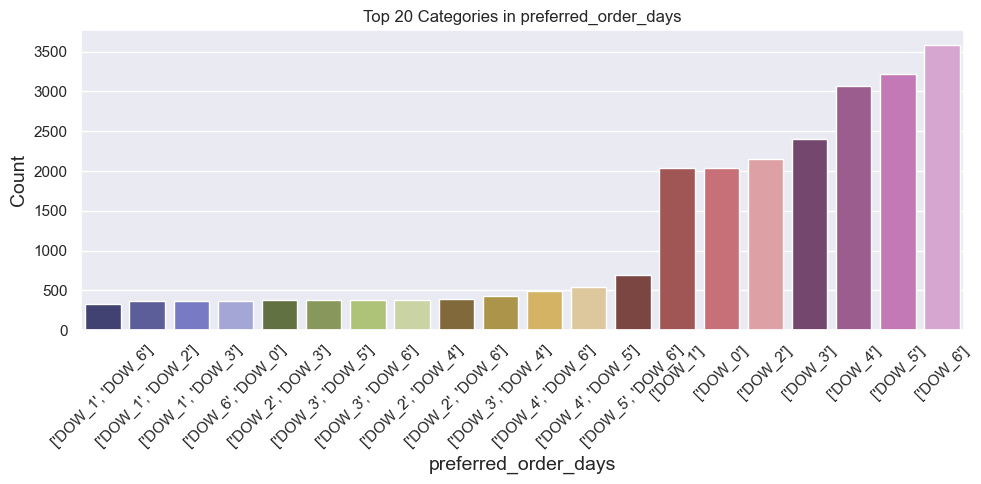

/var/folders/9b/jd3m9d1938sb3269cy5k5rzh0000gn/T/ipykernel_93003/4220566542.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_filtered,


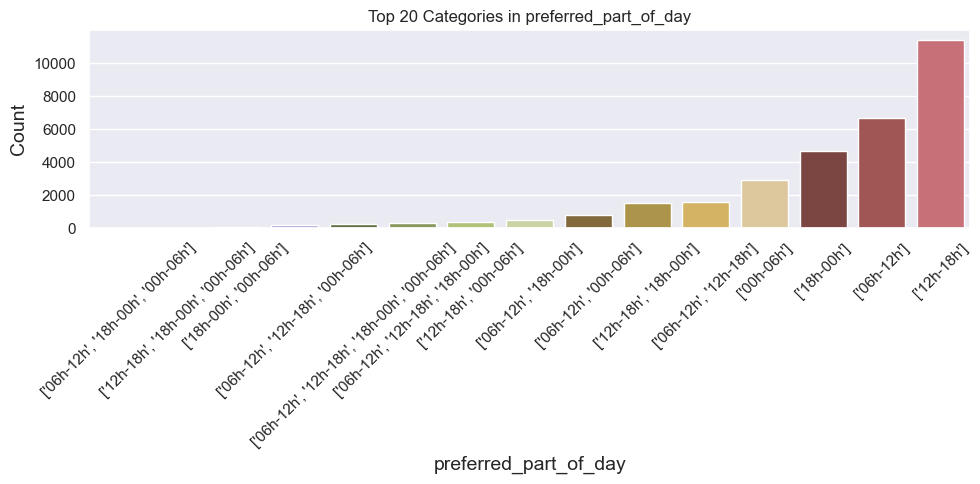

In [59]:
for column in new_non_metric_features:
    
    top_categories = df[column].value_counts().head(20)

    top_categories_sorted = top_categories.sort_values(ascending=True)

    data_filtered = df[df[column].isin(top_categories_sorted.index)]
    
   
    plt.figure(figsize=(10, 5))
    sns.countplot(data=data_filtered, 
                  x=column, 
                  order=top_categories_sorted.index,  
                  palette='tab20b')
    
  
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title(f'Top 20 Categories in {column}')
    
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Treat missing values in new features:

In [60]:
# Percentage of missing values in each variable:
missing_percentage = ((df[new_features].isnull().sum() / len(df)) * 100).sort_values(ascending=False)
missing_percentage = missing_percentage[missing_percentage > 0]

print(f"Percentage of missing values:\n {missing_percentage}")

Percentage of missing values:
 avg_per_order         0.440529
avg_per_product       0.440529
loyalty_to_venders    0.440529
chain_preference      0.440529
avg_order_size        0.440529
dtype: float64


Fill numerical missing values with median:

In [61]:
median_variables = ['avg_per_product', 'avg_per_order', 'avg_order_size', 'chain_preference', 'loyalty_to_venders']
for column in median_variables:
    median_value = df[column].median()
    df[column] = df[column].fillna(median_value)

Percentage of missing values in each variable:

In [62]:
missing_percentage = ((df[new_features].isnull().sum() / len(df)) * 100).sort_values(ascending=False)
missing_percentage = missing_percentage[missing_percentage > 0]

print(f"Percentage of missing values:\n {missing_percentage}")

Percentage of missing values:
 Series([], dtype: float64)


Store the index of rows with missing values in new_features and filter the DataFrame using the index:

In [63]:
missing_rows_index = df[missing_rows].index

df_missing = df.loc[missing_rows_index]
df_missing

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,lifetime_days,preferred_order_days,preferred_part_of_day,total_expenses,avg_per_product,avg_per_order,avg_order_size,culinary_variety,chain_preference,loyalty_to_venders
1326,8670.0,22.0,0,0.0,1,1.0,1,DELIVERY,DIGI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,"[DOW_1, DOW_2, DOW_3, DOW_4, DOW_5, DOW_6, DOW_0]","[06h-12h, 12h-18h, 18h-00h, 00h-06h]",0.0,6.9525,8.216667,1.166667,0.0,0.724747,1.0
1353,8670.0,26.0,0,0.0,0,1.0,1,DELIVERY,CASH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,"[DOW_1, DOW_2, DOW_3, DOW_4, DOW_5, DOW_6, DOW_0]","[06h-12h, 12h-18h, 18h-00h, 00h-06h]",0.0,6.9525,8.216667,1.166667,0.0,0.724747,1.0
1365,8670.0,21.0,0,0.0,1,1.0,1,DELIVERY,DIGI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,"[DOW_1, DOW_2, DOW_3, DOW_4, DOW_5, DOW_6, DOW_0]","[06h-12h, 12h-18h, 18h-00h, 00h-06h]",0.0,6.9525,8.216667,1.166667,0.0,0.724747,1.0
2284,8670.0,38.0,0,0.0,0,2.0,2,DELIVERY,CASH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,"[DOW_1, DOW_2, DOW_3, DOW_4, DOW_5, DOW_6, DOW_0]","[06h-12h, 12h-18h, 18h-00h, 00h-06h]",0.0,6.9525,8.216667,1.166667,0.0,0.724747,1.0
3138,8670.0,24.0,0,0.0,0,3.0,3,DELIVERY,CASH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,"[DOW_1, DOW_2, DOW_3, DOW_4, DOW_5, DOW_6, DOW_0]","[06h-12h, 12h-18h, 18h-00h, 00h-06h]",0.0,6.9525,8.216667,1.166667,0.0,0.724747,1.0
3152,8670.0,25.0,0,0.0,0,3.0,3,DELIVERY,CARD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,"[DOW_1, DOW_2, DOW_3, DOW_4, DOW_5, DOW_6, DOW_0]","[06h-12h, 12h-18h, 18h-00h, 00h-06h]",0.0,6.9525,8.216667,1.166667,0.0,0.724747,1.0
5836,8670.0,32.0,0,0.0,0,6.0,6,DELIVERY,DIGI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,"[DOW_1, DOW_2, DOW_3, DOW_4, DOW_5, DOW_6, DOW_0]","[06h-12h, 12h-18h, 18h-00h, 00h-06h]",0.0,6.9525,8.216667,1.166667,0.0,0.724747,1.0
6727,8670.0,29.0,0,0.0,1,7.0,7,DELIVERY,CARD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,"[DOW_1, DOW_2, DOW_3, DOW_4, DOW_5, DOW_6, DOW_0]","[06h-12h, 12h-18h, 18h-00h, 00h-06h]",0.0,6.9525,8.216667,1.166667,0.0,0.724747,1.0
6756,8670.0,17.0,0,0.0,1,7.0,7,DELIVERY,CASH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,"[DOW_1, DOW_2, DOW_3, DOW_4, DOW_5, DOW_6, DOW_0]","[06h-12h, 12h-18h, 18h-00h, 00h-06h]",0.0,6.9525,8.216667,1.166667,0.0,0.724747,1.0
6770,8670.0,24.0,0,0.0,1,7.0,7,DELIVERY,CASH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,"[DOW_1, DOW_2, DOW_3, DOW_4, DOW_5, DOW_6, DOW_0]","[06h-12h, 12h-18h, 18h-00h, 00h-06h]",0.0,6.9525,8.216667,1.166667,0.0,0.724747,1.0


Outliers:

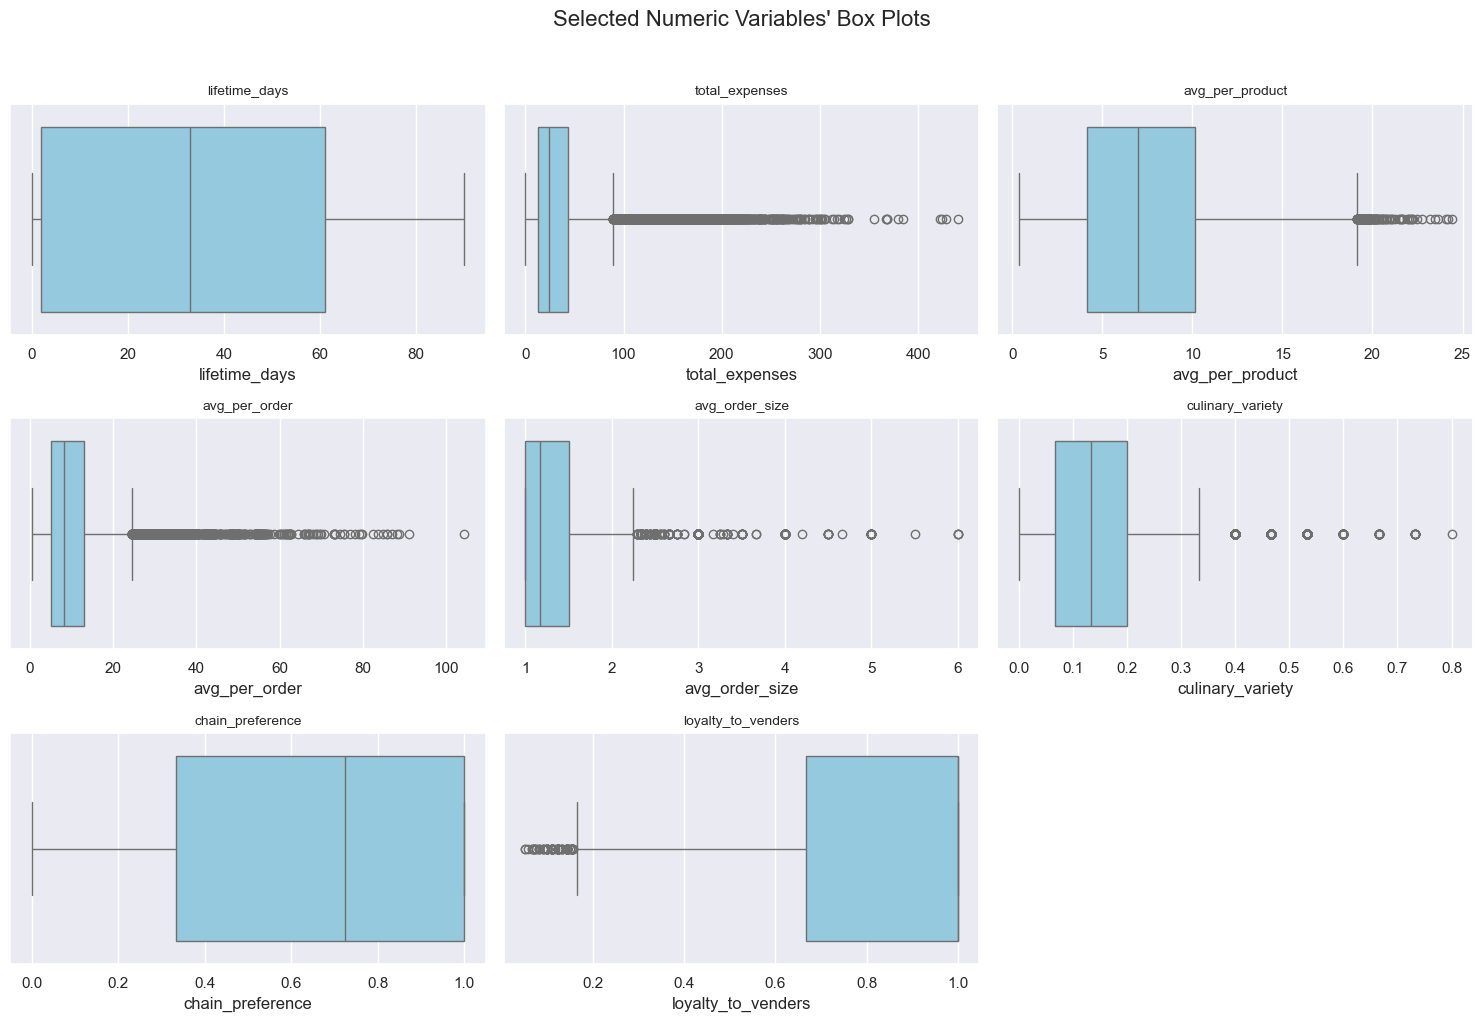

In [64]:
sns.set()


selected_features = new_metric_features

# Set up the figure and axes
rows, cols = 3, 3  #
fig, axes = plt.subplots(rows, cols, figsize=(15, 10)) 

# Flatten axes for iteration
axes = axes.flatten()

# Plot each feature as a box plot
for i, (ax, feat) in enumerate(zip(axes, selected_features)):
    sns.boxplot(data=df, x=feat, ax=ax, color='skyblue')  
    ax.set_title(feat, fontsize=10)  
    
# Hide any unused subplots:
for ax in axes[len(selected_features):]:
    ax.set_visible(False)

# Set a global title and adjust layout
plt.suptitle("Selected Numeric Variables' Box Plots", fontsize=16, y=1.02)  
plt.tight_layout()
plt.show()

Outlier Removal using automatic method:

In [65]:
# Compute the interquartile range
q1 = df[new_metric_features].quantile(0.25)
q3 = df[new_metric_features].quantile(0.75)
iqr = q3 - q1

# Compute the limits:
lower_lim = q1 - (1.5 * iqr)
upper_lim = q3 + (1.5 * iqr)

for feature in new_metric_features:
    print(f"{feature:<25}  Lower Limit: {lower_lim[feature].round(5):>10}      Upper Limit: {upper_lim[feature].round(5):>10}")

lifetime_days              Lower Limit:      -86.5      Upper Limit:      149.5
total_expenses             Lower Limit:  -33.29625      Upper Limit:   89.41375
avg_per_product            Lower Limit:   -4.84249      Upper Limit:   19.12859
avg_per_order              Lower Limit:   -6.58605      Upper Limit:   24.52763
avg_order_size             Lower Limit:       0.25      Upper Limit:       2.25
culinary_variety           Lower Limit:   -0.13333      Upper Limit:        0.4
chain_preference           Lower Limit:   -0.66667      Upper Limit:        2.0
loyalty_to_venders         Lower Limit:    0.16667      Upper Limit:        1.5


Observations in which all features are outliers:

In [66]:
outliers, obvious_outliers = identify_outliers(df, new_metric_features, lower_lim, upper_lim)

Total outliers in lifetime_days: 0
Total outliers in total_expenses: 2364
Total outliers in avg_per_product: 167
Total outliers in avg_per_order: 1629
Total outliers in avg_order_size: 701
Total outliers in culinary_variety: 1145
Total outliers in chain_preference: 0
Total outliers in loyalty_to_venders: 105
-----------------------------
Total global outliers: 0


Conclusion: There is no observation in which all new features is an outlier. 

There is no outlier in 'lifetime_days', 'chain_preference'.

Check if there is any observation only with outliers, except on these features.

In [67]:
new_metric_features_test = ['total_expenses', 'avg_per_product', 'avg_per_order', 'avg_order_size', 'culinary_variety', 'loyalty_to_venders']
outliers, obvious_outliers = identify_outliers(df, new_metric_features_test, lower_lim, upper_lim)

Total outliers in total_expenses: 2364
Total outliers in avg_per_product: 167
Total outliers in avg_per_order: 1629
Total outliers in avg_order_size: 701
Total outliers in culinary_variety: 1145
Total outliers in loyalty_to_venders: 105
-----------------------------
Total global outliers: 0


Conclusion: There is no observation with outliers in all new features.

Observations in which at least one new feature is an outlier:

In [68]:
new_filters_iqr = []                                            
for metric in new_metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    new_filters_iqr.append(df[metric].between(llim, ulim, inclusive='neither'))

new_filters_iqr_all = pd.concat(new_filters_iqr, axis=1).all(axis=1)

In [69]:
new_filters_iqr_all

0        False
1         True
2         True
3         True
4        False
5         True
6         True
7         True
8         True
9         True
10        True
11        True
12        True
13        True
14        True
15        True
16        True
17        True
18        True
19        True
20        True
21        True
22        True
23        True
24        True
25        True
26        True
27        True
28        True
29        True
30        True
31        True
32        True
33        True
34        True
35        True
36        True
37        True
38        True
39        True
40        True
41        True
42        True
43        True
44        True
45        True
46       False
47        True
48        True
49        True
50        True
51        True
52        True
53        True
54        True
55        True
56        True
57        True
58        True
59       False
60        True
61        True
62        True
63        True
64        True
65        True
66        

In [70]:
# Number of observations with at least one features considered an outlier
new_features_percentage_data_kept = len(df[new_filters_iqr_all])/len(df)*100
new_features_percentage_outliers = round(100 - new_features_percentage_data_kept, 5)
print(f"Percentage of observations with at least one features considered an outlier: {new_features_percentage_outliers}%")
print(f"Percentage of data kept after removing outliers: {new_features_percentage_data_kept}%")

Percentage of observations with at least one features considered an outlier: 15.64834%
Percentage of data kept after removing outliers: 84.35165677073357%


Outliers removal using manual method:

In [71]:
filters_manual_new_features = (
                (df["total_expenses"] <= 350) #
                &
                (df["avg_per_product"] <= 22) #??
                &
                (df["avg_per_order"] <= 70)  #50                          
                &
                (df["avg_order_size"] <= 4)                                  
                &
                (df["culinary_variety"] <= 0.7)
                &
                (df["loyalty_to_venders"] >= 0.1)
)                     

df_out_man_new_features = df[filters_manual_new_features]

In [72]:
# Number of observations with at least one features considered an outlier
new_features_percentage_data_kept_manual = 100*(np.round(df_out_man_new_features.shape[0] / df.shape[0], decimals=5))
new_features_percentage_outliers_manual = round(100 - new_features_percentage_data_kept_manual, 5)
print(f"Percentage of observations with at least one features considered an outlier: {new_features_percentage_outliers_manual}%")
print(f"Percentage of data kept after removing outliers: {new_features_percentage_data_kept_manual}%")

Percentage of observations with at least one features considered an outlier: 0.287%
Percentage of data kept after removing outliers: 99.713%


Remove outliers combining automatic and manual methods:

In [73]:
df = df[(new_filters_iqr_all | filters_manual_new_features)]

## <span style="color:salmon">3.3 Visualize all features </span> 

In [74]:
all_metric_features = [
    'customer_age', 'vendor_count', 'product_count', 'is_chain', 'first_order', 
    'last_order', 'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 
    'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 
    'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 
    'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'DOW_0', 'DOW_1', 
    'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0', 'HR_1', 'HR_2', 
    'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11', 
    'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 
    'HR_20', 'HR_21', 'HR_22', 'HR_23', 'lifetime_days', 'total_expenses', 
    'avg_per_product', 'avg_per_order', 'avg_order_size', 'culinary_variety', 
    'chain_preference', 'loyalty_to_venders'
]

all_non_metric_features = [
    'customer_region', 'last_promo', 'payment_method', 
    'preferred_order_days', 'preferred_part_of_day'
]

len(all_metric_features)

60

#### <span style="color:salmon"> 3.3.1 Numerical Features </span>

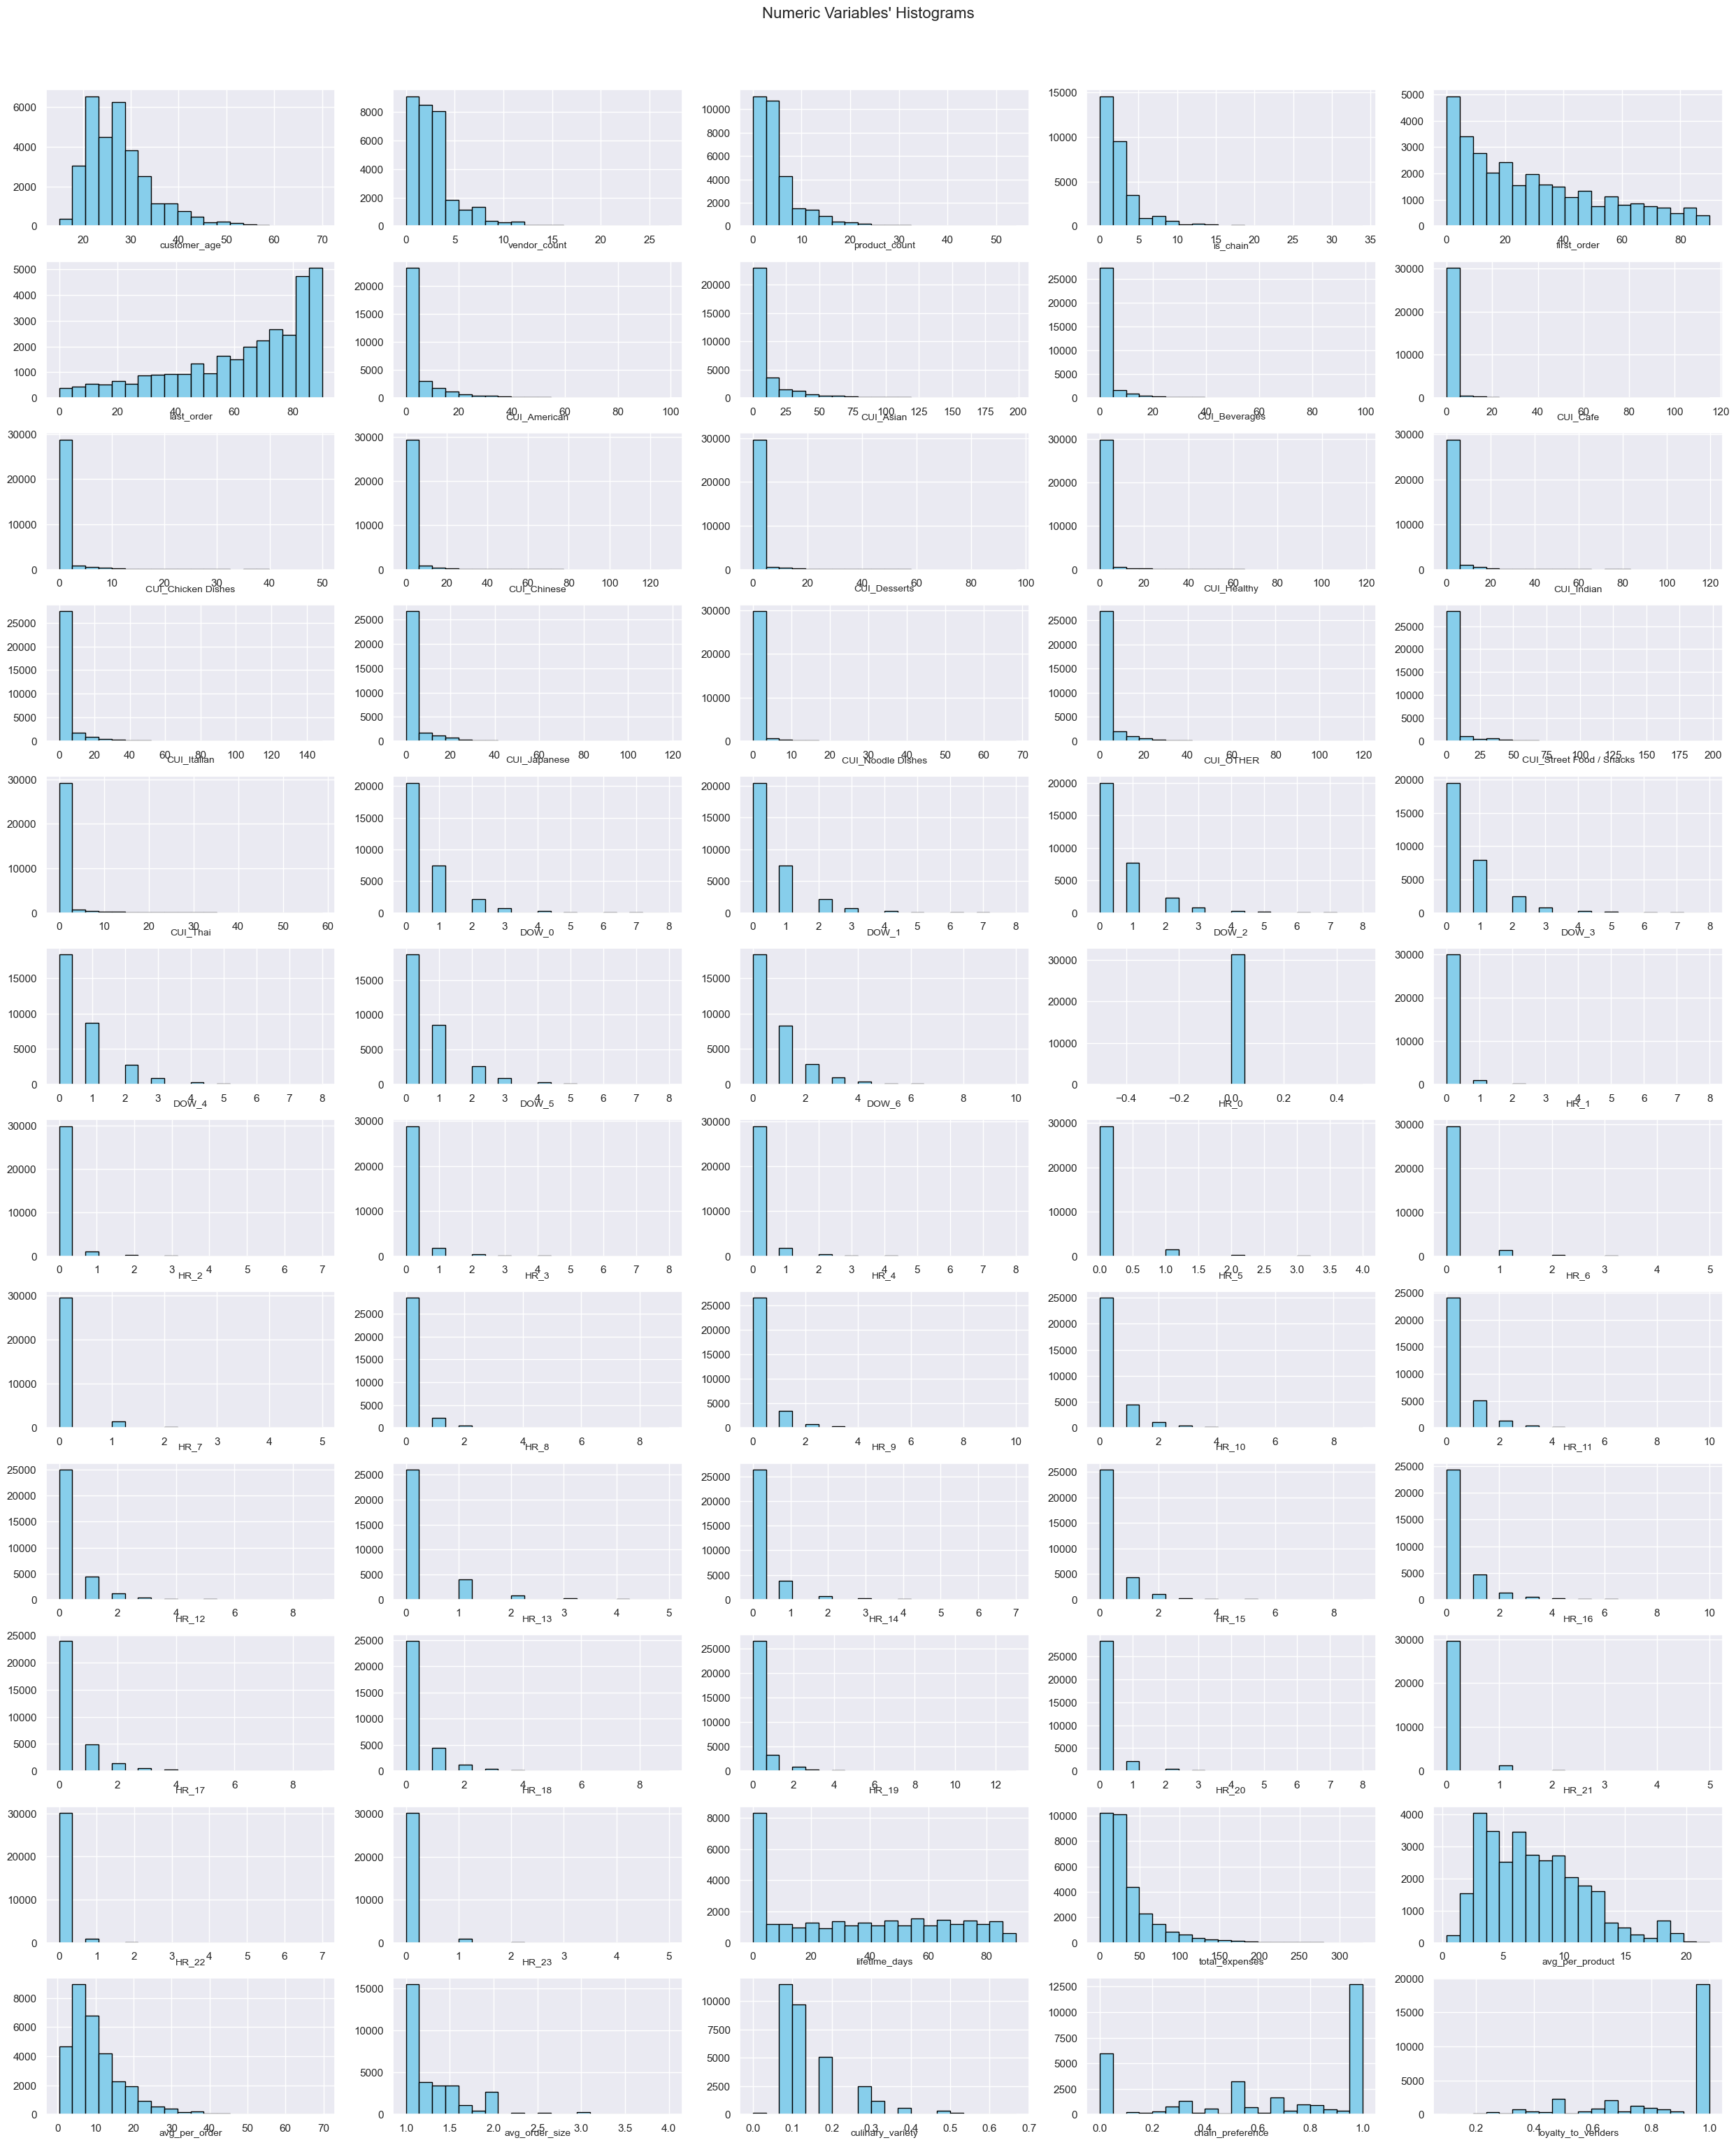

In [75]:
sns.set()

# Set up the figure and axes
rows, cols = 12, 5  
fig, axes = plt.subplots(rows, cols, figsize=(25, 30)) 

# Plot each feature
for ax, feat in zip(axes.flatten(), all_metric_features):
    ax.hist(df[feat], bins=20, color='skyblue', edgecolor='black')  
    ax.set_title(feat, fontsize=10, y=-0.2)  

# Hide unused subplots:
for ax in axes.flatten()[len(all_metric_features):]:
    ax.set_visible(False)

# Set a global title and adjust layout 
plt.suptitle("Numeric Variables' Histograms", fontsize=16, y=1.02)  
plt.tight_layout() 
plt.show()

#### <span style="color:salmon"> 3.3.2 Categorical Features </span>

/var/folders/9b/jd3m9d1938sb3269cy5k5rzh0000gn/T/ipykernel_93003/994731618.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_filtered,


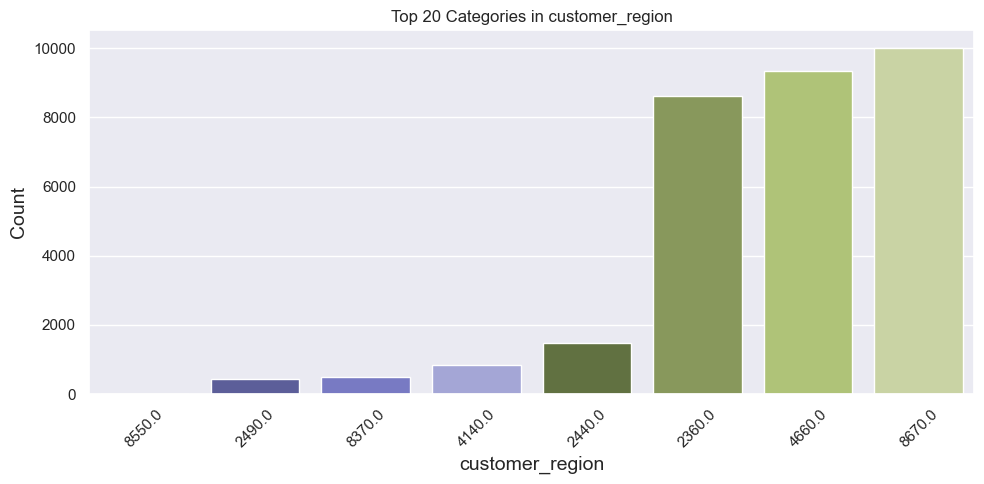

/var/folders/9b/jd3m9d1938sb3269cy5k5rzh0000gn/T/ipykernel_93003/994731618.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_filtered,


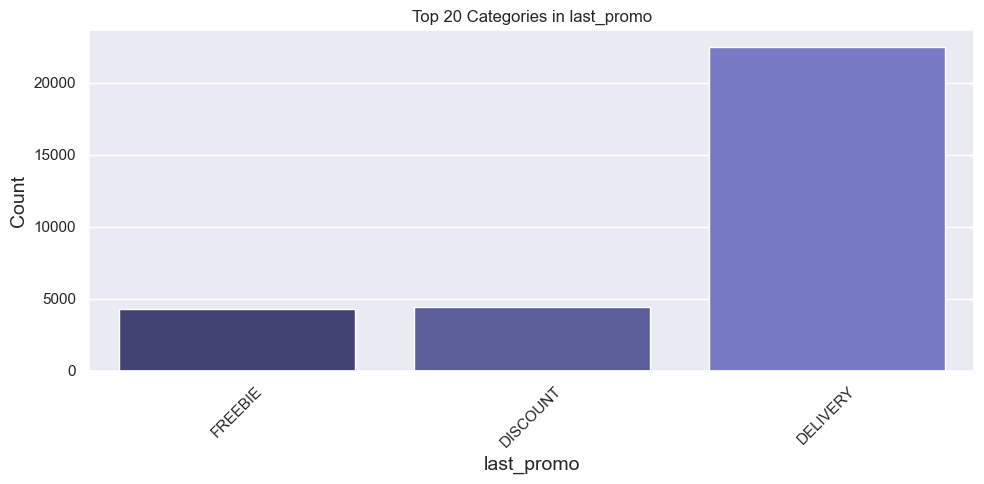

/var/folders/9b/jd3m9d1938sb3269cy5k5rzh0000gn/T/ipykernel_93003/994731618.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_filtered,


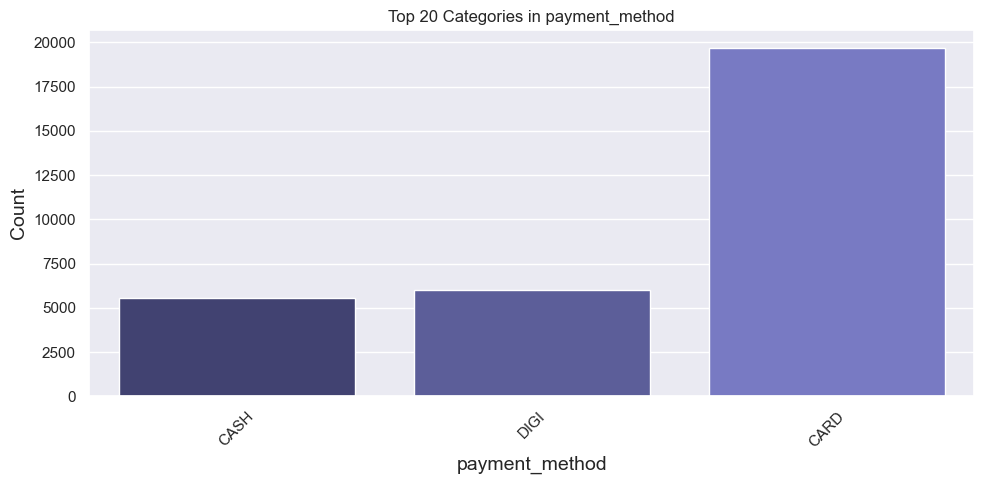

/var/folders/9b/jd3m9d1938sb3269cy5k5rzh0000gn/T/ipykernel_93003/994731618.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_filtered,


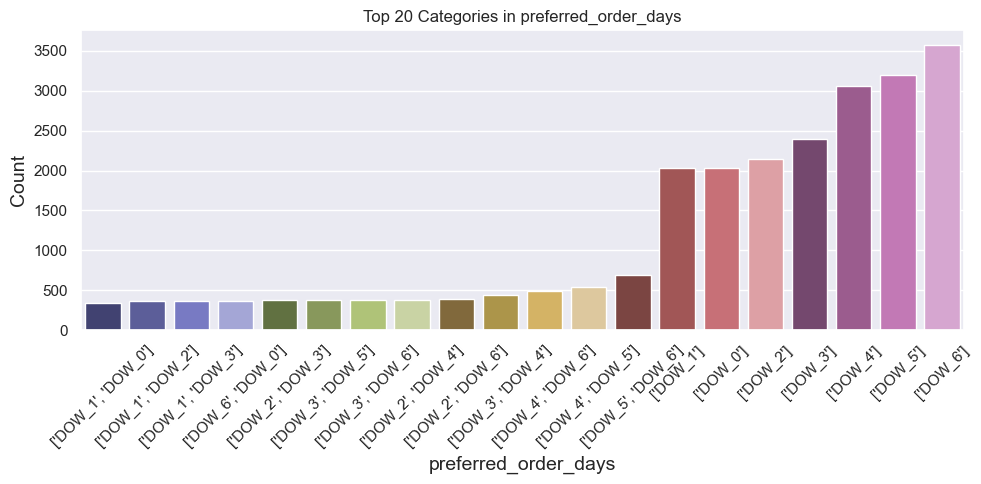

/var/folders/9b/jd3m9d1938sb3269cy5k5rzh0000gn/T/ipykernel_93003/994731618.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_filtered,


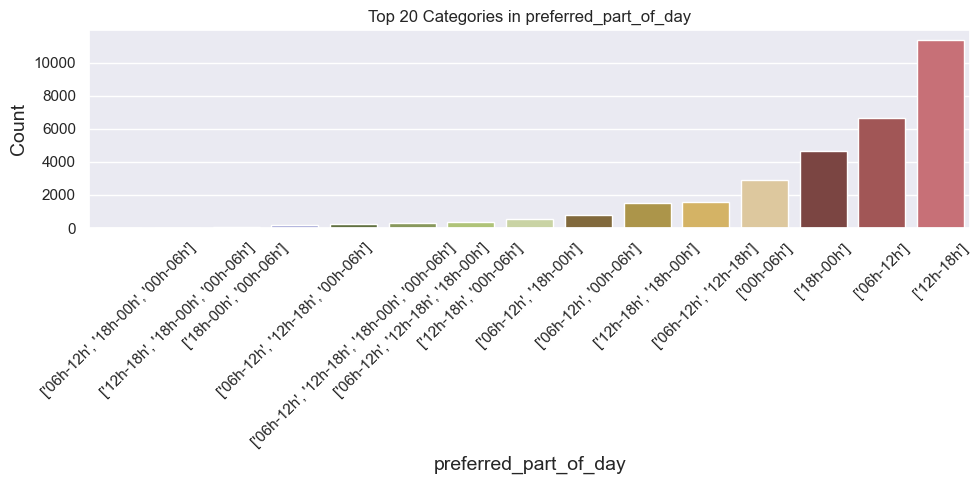

In [76]:
for column in all_non_metric_features:
    
    top_categories = df[column].value_counts().head(20)

    top_categories_sorted = top_categories.sort_values(ascending=True)

    data_filtered = df[df[column].isin(top_categories_sorted.index)]
    
   
    plt.figure(figsize=(10, 5))
    sns.countplot(data=data_filtered, 
                  x=column, 
                  order=top_categories_sorted.index,  
                  palette='tab20b')
    
  
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title(f'Top 20 Categories in {column}')
    
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [77]:
# Store in df_new_features the DataFrame of our dataset df
df_new_features = pd.DataFrame(df)

# Save to CSV
df_new_features.to_csv('../dataset/df_new_features.csv', index=False)